In [1]:
# read h5file with simmulated zf song
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
import h5py
import copy
import glob
import shutil

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
from swissknife.h5tools import h5tools
from swissknife.h5tools import tables
from swissknife.dynamo import finch as zf
from swissknife.dynamo import takens as tk
from swissknife.bci.core import expstruct as es
from swissknife.threadtools import threadedfunction as td
from swissknife.streamtools import spectral as sp

2017-05-06 22:01:05,984 root         INFO     Computer: passaro


In [23]:
import scipy

In [2]:
sweep_id = '002'
sweep_name = 'sweep_'+sweep_id
file_name_base = 'finch_'+sweep_id 
sweep_folder = os.path.join(es.file_names('')['folders']['tmp'], 'syn_sweeps')
sweep_file_name = '{}.h5'.format(file_name_base)
sweep_file_path = os.path.join(sweep_folder, sweep_file_name)

In [3]:
import pandas as pd
from swissknife.streamtools import streams as st

def load_sweep_pars(sweep_file, sweep_name):
    sweep_group = sweep_file['/{}'.format(sweep_name)]
    print sweep_group['vocal_pars'].items()
    sweep_pars = h5tools.group_2_dict({}, sweep_group['vocal_pars'], 'sweep_pars')
    return sweep_pars['sweep_pars']


class ParSweep(object):
    def __init__(self, sweep_file, sweep_name, streams=['pre_in', 'pre_out'], transient_ms=50):
        self.sweep_file = sweep_file
        self.pars = load_sweep_pars(sweep_file, sweep_name)
        tables_path = '/{0}/synth/{1:d}'.format(sweep_name,
                                                 int(self.pars['sys']['gamma']))
        logger.info('Tables are in {}'.format(tables_path))
        self.sweep_tables_group = sweep_file[tables_path]
        logger.info('Groups: {}'.format(self.sweep_tables_group.items()))

        self.ab = pd.DataFrame(self.sweep_tables_group['alpha_beta'][()])
        self.ab.columns = ['a', 'b']
        self.transient_samples = int(transient_ms*0.001*self.pars['sys']['s_f'])
        self.syn_streams = {stream: st.H5Data(self.sweep_tables_group[stream], 
                                            self.pars['sys']['s_f']) for stream in streams}
        
    def synthetic(self, row, rows=0, stream='pre_out'):
        #get index of alpha, beta
        return self.syn_streams[stream].get_chunk(row, row + rows, 
                                                  np.arange(self.transient_samples, 
                                                            self.syn_streams[stream].n_chans)
                                                           )      

import tensorflow as tf


def regularize(u, cut_off=75, logarithmic=True):
    cut_db = 1./np.exp(cut_off/10)
    
    y_thresh = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)*cut_db
    
    if logarithmic:
        u[u < y_thresh] = np.amin(y_thresh)
        z = np.log(u)
    else:
        u[u < y_thresh] = np.amin(y_thresh)
        z = u
    
    return z

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

# with h5py.File(sweep_file_path, 'r') as sweep_file:
#     #s_p = load_sweep_pars(sweep_file, sweep_name)
#     p_s = ParSweep(sweep_file, sweep_name)
#     one_stream = p_s.synthetic(153915)
    
sweep_file = h5py.File(sweep_file_path, 'r')
p_s = ParSweep(sweep_file, sweep_name)

2017-05-06 22:01:12,605 h5tools      DEBUG    Translating group sweep_pars into its own dictionary
2017-05-06 22:01:12,610 h5tools      DEBUG    Subgroup sys
2017-05-06 22:01:12,612 h5tools      DEBUG    Translating group sys into its own dictionary
2017-05-06 22:01:12,616 root         INFO     Tables are in /sweep_002/synth/23500
2017-05-06 22:01:12,619 root         INFO     Groups: [(u'alpha_beta', <HDF5 dataset "alpha_beta": shape (160000, 2), type "<f8">), (u'pre_in', <HDF5 dataset "pre_in": shape (160000, 4410), type "<f8">), (u'pre_out', <HDF5 dataset "pre_out": shape (160000, 4410), type "<f8">)]


[(u'sys', <HDF5 group "/sweep_002/vocal_pars/sys" (0 members)>)]


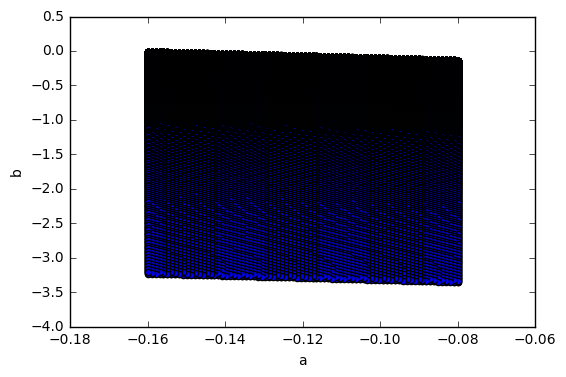

In [4]:
p_s.ab.plot.scatter('a', 'b')

In [5]:
p_s.ab.loc[(p_s.ab['a'] > -0.15) & (p_s.ab['a'] < -0.146)]

,a,b
22000,-0.146835,-0.033812
22001,-0.146835,-0.034264
22002,-0.146835,-0.034723
22003,-0.146835,-0.035188
22004,-0.146835,-0.035659
22005,-0.146835,-0.036137
22006,-0.146835,-0.036622
22007,-0.146835,-0.037113
22008,-0.146835,-0.037612
22009,-0.146835,-0.038117


In [6]:
# same spectrogram as used for actual data
def spectrogram(x, s_f, n_perseg = None, n_overlap=None, cut_off=90, f_min=0., f_max=10000.):
    f, t, s = scipy.signal.spectrogram(x, fs=s_f, window=('tukey', 0.25), 
                         nperseg=n_perseg, 
                         noverlap=n_overlap, 
                         nfft=None, 
                         detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

    s[s<np.max(s)/np.exp(cut_off/10)]=np.max(s)/np.exp(cut_off/10)
    f_filter = np.where((f>f_min) & (f<f_max))
    return f[f_filter], t, s[f_filter]

30000.0

In [61]:
from tqdm import tqdm

n_streams = p_s.ab.shape[0]
f_bins = 512
n_samples = f_bins * 2 # resolution of fft is given by n of samples
s_f = p_s.pars['sys']['s_f']
f_min = 150
f_max = 7500

aux_spectra = np.zeros([n_streams, f_bins], dtype=np.float32)
rows_chunk = 1000
for i in tqdm(np.arange(int(n_streams/rows_chunk))):
#for i in tqdm(np.arange(1)):
    x_i = p_s.synthetic(i*rows_chunk, rows=rows_chunk)[:, :n_samples]
    f, t, s = spectrogram(x_i.flatten(), s_f, n_perseg=n_samples, n_overlap=0, f_min=f_min, f_max=f_max)
    aux_spectra[i*rows_chunk:(i+1)*rows_chunk, :f.size] = s.T

all_spectra = aux_spectra[:, :f.size]

100%|██████████| 160/160 [00:12<00:00, 12.92it/s]


In [62]:
all_spectra = normalize(all_spectra)

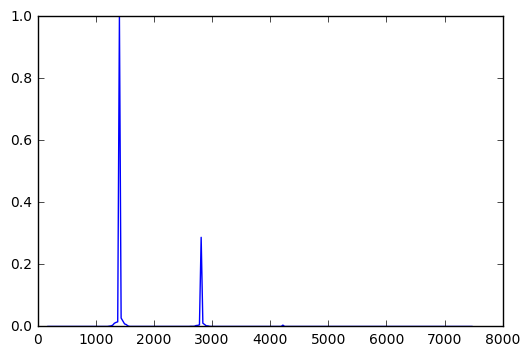

In [63]:
plt.plot(f, all_spectra[100])

In [66]:
import pickle

syll_data = pd.DataFrame({
        'bird': ['synth' for i in range(all_spectra.shape[0])],
        'sess': [sweep_name for i in range(all_spectra.shape[0])],
        'a': np.array(p_s.ab['a']).tolist(),
        'b': np.array(p_s.ab['b']).tolist(),
        'spectral': normalize(all_spectra).tolist()
    })

spectral_synth = {
    'f': f,
    'spectral_pd': syll_data,
    's_f': s_f,
    'syn_pars': p_s.pars
}

#syll_data.to_pickle(os.path.join(sweep_folder, 'spectral_pandas_{}.pickle'.format(sweep_name)))
store_path = os.path.join(sweep_folder, 'syn_spectral_{0}_{1:04d}.pickle'.format(sweep_name, f_bins))

with open(store_path, 'wb') as output: 
    pickle.dump(spectral_synth, output)
print(store_path)


/usr/local/experiment/tmp_data/syn_sweeps/syn_spectral_sweep_002_0512.pickle


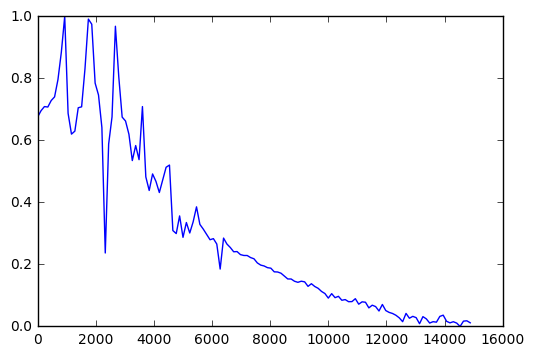

In [9]:
f = np.arange(f_bins)*p_s.pars['sys']['s_f']/f_bins/2
plt.plot(f, all_spectra[i_stream, :])

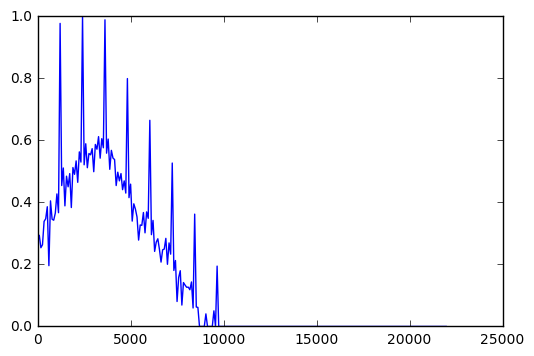

In [15]:
def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u - u_min)/u_range

plt.plot(f, normalize(all_spectra)[i_stream, :])

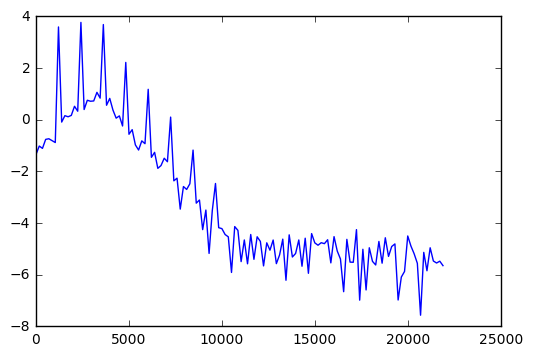

In [165]:
plt.plot(f, np.log(all_spectra[i_stream, :]))

In [166]:
regularize(all_spectra)[i_stream, :]

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log


TypeError: 'NoneType' object has no attribute '__getitem__'

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log


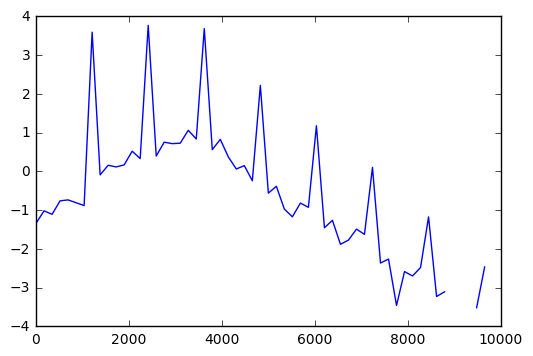

In [148]:
plt.plot(f, regularize(all_spectra)[i_stream, :])

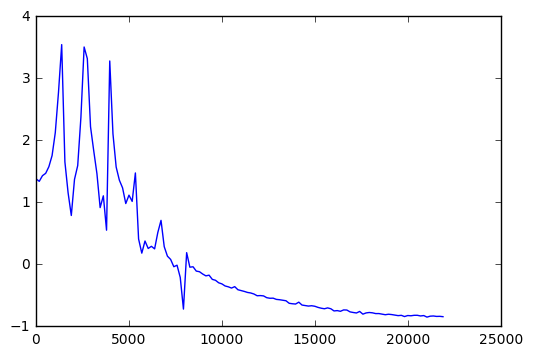

In [119]:
yy = all_spectra[:50]
y_thresh = np.repeat(np.amax(yy, axis = 1, keepdims=True), yy.shape[-1], axis=1)/np.exp(90/10)
yy[yy<y_thresh]=0
plt.plot(f, np.log(yy[20,:]))

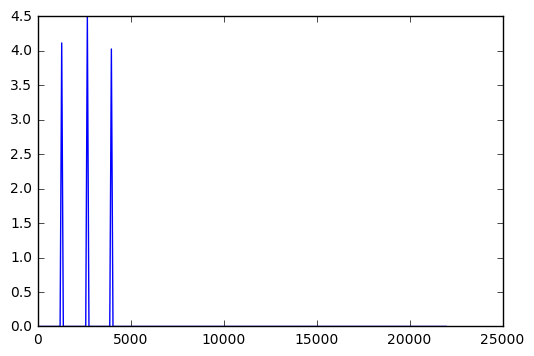

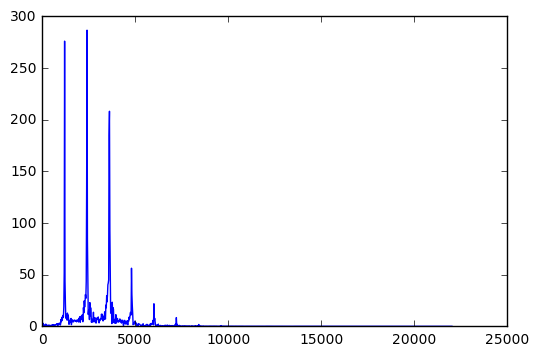

In [35]:
f = np.arange(y.shape[1])*p_s.pars['sys']['s_f']/y.shape[-1]/2
plt.plot(f, y[i_stream,:])

In [8]:
i=1000
print(i)
x = p_s.synthetic(i).flatten()[:2048]
s = spectral_slice_tf(x)
plt.plot(f, s)

1000


NameError: name 'f' is not defined

In [11]:
p_s.ab.shape[0]

160000

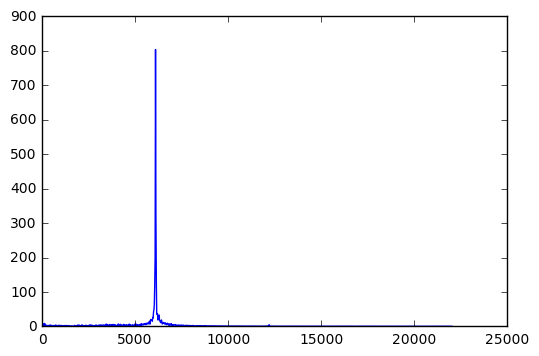

In [33]:
s = spectral_slice_tf(x)
f = np.arange(s.size)*p_s.pars['sys']['s_f']/s.size/2
plt.plot(f, s)

In [28]:
p_s.pars['sys']['s_f']

44100.0

In [31]:
1/.15

6.666666666666667

In [74]:
s

array([ 0.00064711,  0.00051946,  0.00043862, ...,  0.00014497,
        0.00014609,  0.00014595], dtype=float32)

In [7]:
f = h5py.File(sweep_file_path, 'r')
p_s = ParSweep(f, sweep_name)
#one_stream = p_s.synthetic(0, 0)

2016-10-28 00:53:07,897 h5tools      DEBUG    Translating group sweep_pars into its own dictionary
2016-10-28 00:53:07,899 h5tools      DEBUG    Translating group sys into its own dictionary


[(u'sys', <HDF5 group "/sweep_000/vocal_pars/sys" (0 members)>)]
/sweep_000/synth/23500
[(u'alpha_beta', <HDF5 dataset "alpha_beta": shape (159500, 2), type "<f8">), (u'pre_in', <HDF5 dataset "pre_in": shape (159500, 4410), type "<f8">), (u'pre_out', <HDF5 dataset "pre_out": shape (159500, 4410), type "<f8">)]


In [40]:
def slice_compare()

(1, 2205)

In [24]:
import h5tools as h5

In [25]:
h5.tables

<module 'h5tools.tables' from '/mnt/cube/earneodo/repos/swissknife/h5tools/tables.pyc'>

In [34]:
np.arange(5, 10)

array([5, 6, 7, 8, 9])